In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

In [158]:
players_data = pd.read_csv("../datasets/visualisation_hw/player_data.csv")
players_data2 = pd.read_csv("../datasets/visualisation_hw/Players.csv")

players_data2.rename(columns={"Player": "name"}, inplace=True)
players_data = players_data.merge(
    players_data2.loc[:, ["name", "height", "weight", "birth_state"]], on="name", how="left"
)
for col in ("height", "weight"):
    players_data[col] = players_data[f"{col}_y"].combine_first(players_data[f"{col}_x"])
    players_data.drop([f"{col}_x", f"{col}_y"], axis=1, inplace=True)

In [159]:
players_data.head()

,name,year_start,year_end,position,birth_date,college,birth_state,height,weight
0,Alaa Abdelnaby,1991,1995,F-C,"June 24, 1968",Duke University,Egypt,208.0,108.0
1,Zaid Abdul-Aziz,1969,1978,C-F,"April 7, 1946",Iowa State University,New York,206.0,106.0
2,Kareem Abdul-Jabbar,1970,1989,C,"April 16, 1947","University of California, Los Angeles",NaN,7-2,225.0
3,Mahmoud Abdul-Rauf,1991,2001,G,"March 9, 1969",Louisiana State University,Delaware,188.0,83.0
4,Tariq Abdul-Wahad,1998,2003,F,"November 3, 1974",San Jose State University,France,198.0,101.0


In [160]:
players_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550 entries, 0 to 4549
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         4550 non-null   object 
 1   year_start   4550 non-null   int64  
 2   year_end     4550 non-null   int64  
 3   position     4549 non-null   object 
 4   birth_date   4519 non-null   object 
 5   college      4248 non-null   object 
 6   birth_state  3353 non-null   object 
 7   height       4550 non-null   object 
 8   weight       4548 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 355.5+ KB


Converting all height to cm

In [161]:
players_data["height"] = players_data["height"].fillna("0-0")
players_data["height"] = players_data["height"].apply(
    lambda x: x if isinstance(x, float) else int(x.split("-")[0]) * 30.48 + int(x.split("-")[1]) * 2.54
)

Calculating the career properties - length, start age & end age

In [162]:
players_data["career_length"] = players_data.apply(lambda player: player["year_end"] - player["year_start"], axis=1)

In [163]:
players_data["birth_date"].isna().sum() / players_data.shape[0]

0.006813186813186814

Remove players without birth's date because visualization will hardly depend on it and there is not a lot of such records

In [164]:
players_data = players_data[players_data["birth_date"].notna()]

In [165]:
def get_decade(date):
    if isinstance(date, str):
        date = date.rsplit(" ")[-1]
    return int(date) - int(date) % 10


players_data["birth_year"] = players_data["birth_date"].apply(get_decade)
players_data["birth_decade"] = players_data["birth_year"].apply(get_decade)
players_data["decade_start"] = players_data["year_start"].apply(get_decade)
players_data["decade_end"] = players_data["year_end"].apply(get_decade)

players_data["age_start"] = players_data["year_start"] - players_data["birth_year"]
players_data["age_end"] = players_data["year_end"] - players_data["birth_year"]

In [166]:
players_data.head()

,name,year_start,year_end,position,birth_date,college,birth_state,height,weight,career_length,birth_year,birth_decade,decade_start,decade_end,age_start,age_end
0,Alaa Abdelnaby,1991,1995,F-C,"June 24, 1968",Duke University,Egypt,208.00,108.0,4,1960,1960,1990,1990,31,35
1,Zaid Abdul-Aziz,1969,1978,C-F,"April 7, 1946",Iowa State University,New York,206.00,106.0,9,1940,1940,1960,1970,29,38
2,Kareem Abdul-Jabbar,1970,1989,C,"April 16, 1947","University of California, Los Angeles",NaN,218.44,225.0,19,1940,1940,1970,1980,30,49
3,Mahmoud Abdul-Rauf,1991,2001,G,"March 9, 1969",Louisiana State University,Delaware,188.00,83.0,10,1960,1960,1990,2000,31,41
4,Tariq Abdul-Wahad,1998,2003,F,"November 3, 1974",San Jose State University,France,198.00,101.0,5,1970,1970,1990,2000,28,33


#### Some features distribution during the time

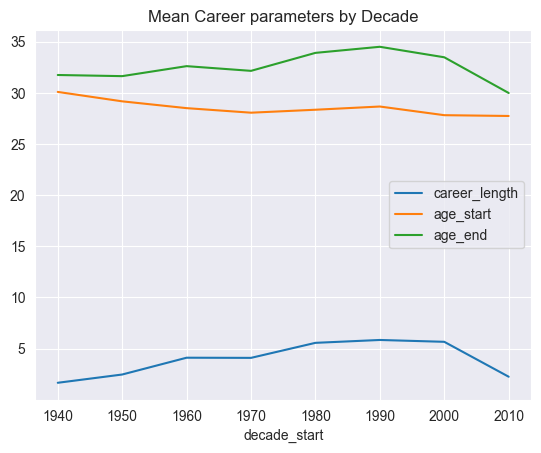

In [167]:
career_parameters_changes = players_data.groupby("decade_start").aggregate(
    {"career_length": "mean", "age_start": "mean", "age_end": "mean"}
)
career_parameters_changes.plot(kind="line")
plt.title("Mean Career parameters by Decade")
plt.show()

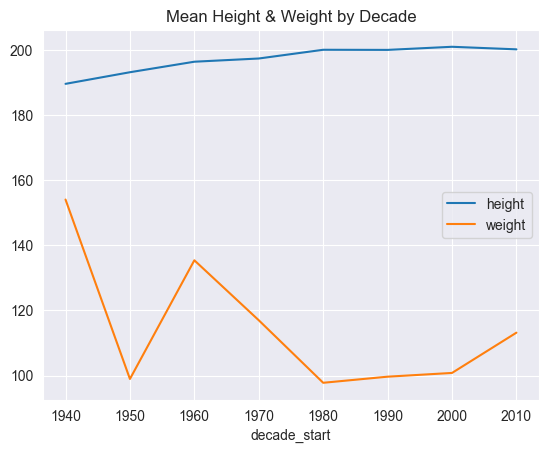

In [168]:
players_data.groupby("decade_start").aggregate({"height": "mean", "weight": "mean"}).plot(kind="line")
plt.title("Mean Height & Weight by Decade")
plt.show()

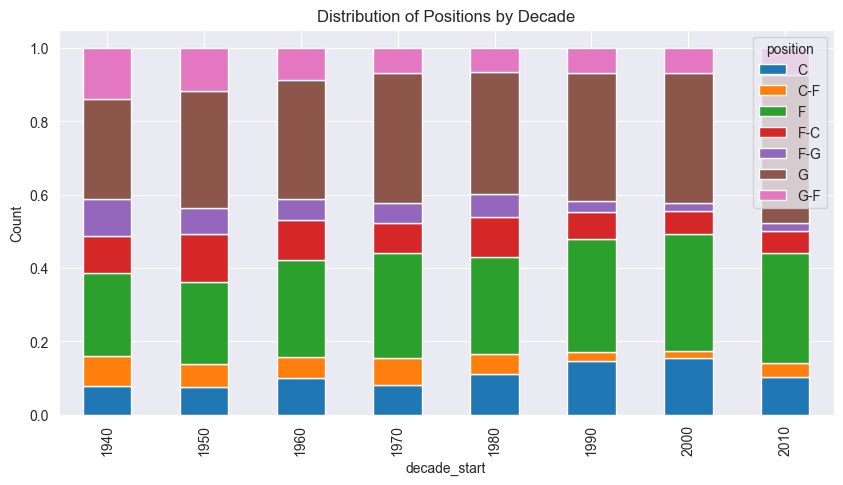

In [169]:
position_counts = players_data.groupby(["decade_start", "position"]).size().unstack()
position_counts = position_counts.div(position_counts.sum(axis=1), axis=0)

position_counts.plot(kind="bar", stacked=True, figsize=(10, 5))
plt.ylabel("Count")
plt.title("Distribution of Positions by Decade")
plt.show()

/var/folders/5m/vtkls86x2_n4srmnn0xjgxs40000gn/T/ipykernel_74011/1747694673.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data_pivot = colleges_popularity.pivot("college", "decade_start", "num_players")


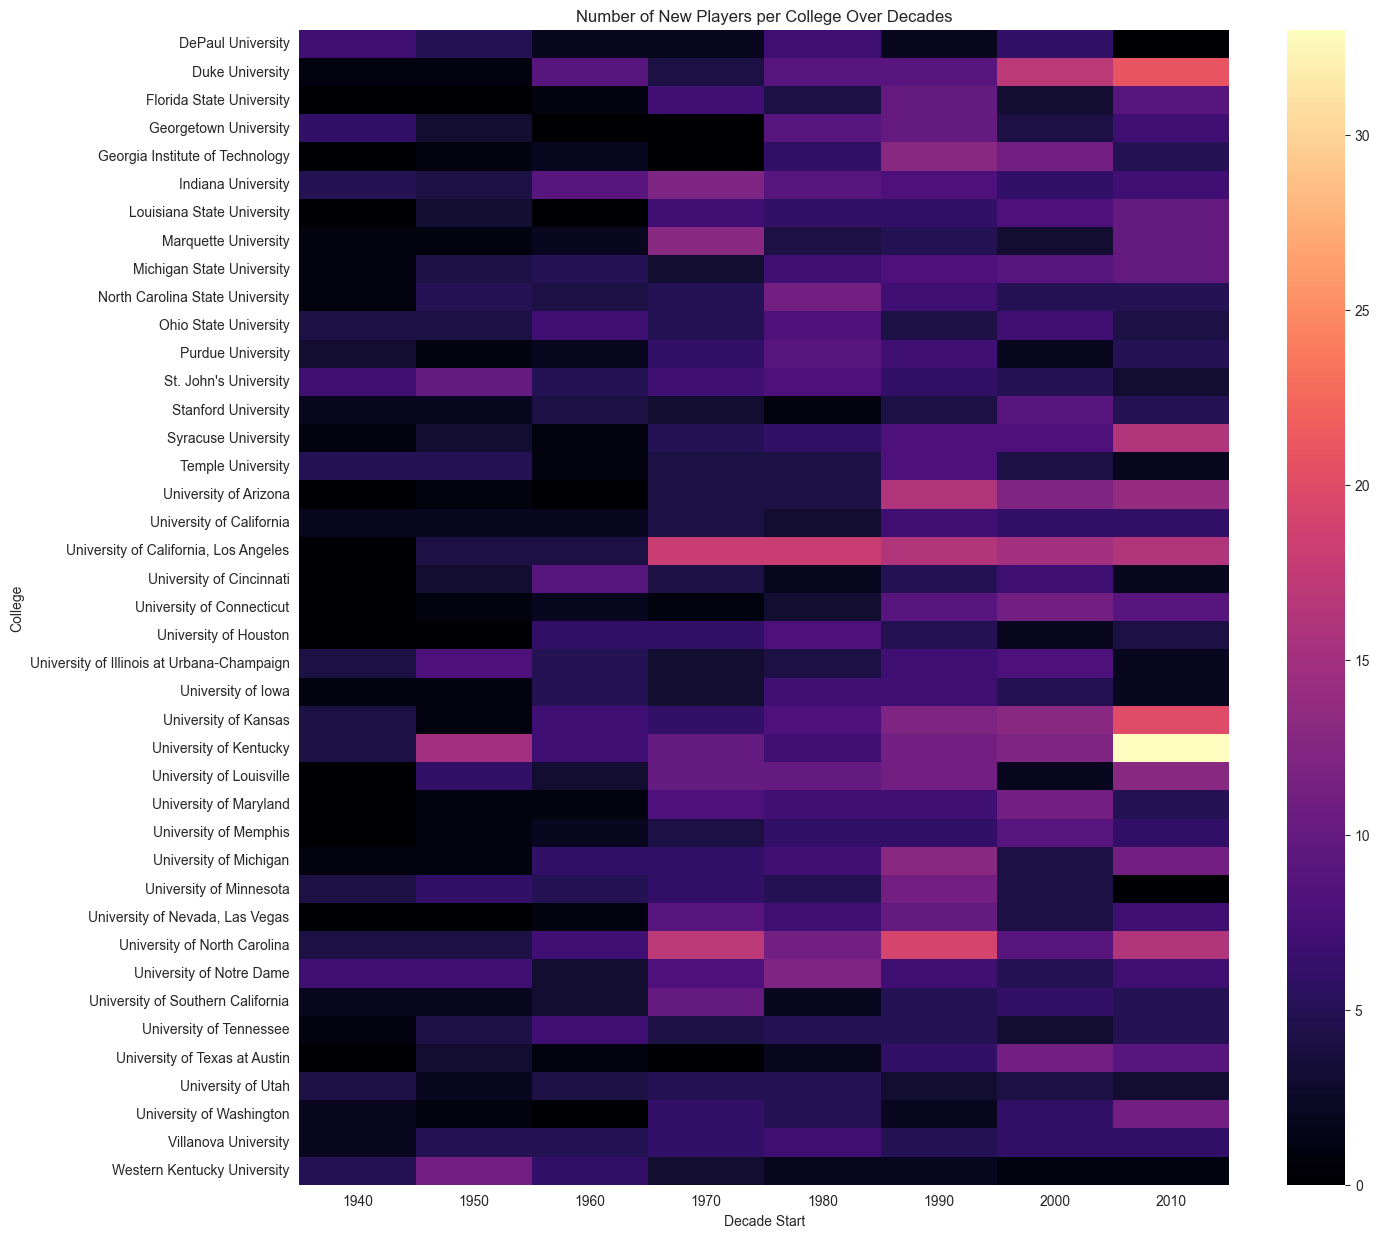

In [170]:
valuable_colleges = players_data.groupby("college").size() >= 30
valuable_colleges_names = valuable_colleges[valuable_colleges].index
colleges_popularity = players_data[players_data["college"].isin(valuable_colleges_names)]

colleges_popularity = colleges_popularity.groupby(["decade_start", "college"]).size().reset_index()
colleges_popularity.columns = ["decade_start", "college", "num_players"]

data_pivot = colleges_popularity.pivot("college", "decade_start", "num_players")
data_pivot = data_pivot.fillna(0)

plt.figure(figsize=(15, 15))
sns.heatmap(data_pivot, cmap="magma")
plt.title("Number of New Players per College Over Decades")
plt.xlabel("Decade Start")
plt.ylabel("College")
plt.show()

/var/folders/5m/vtkls86x2_n4srmnn0xjgxs40000gn/T/ipykernel_74011/1870371493.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data_pivot = states_popularity.pivot("birth_state", "decade_start", "num_players")


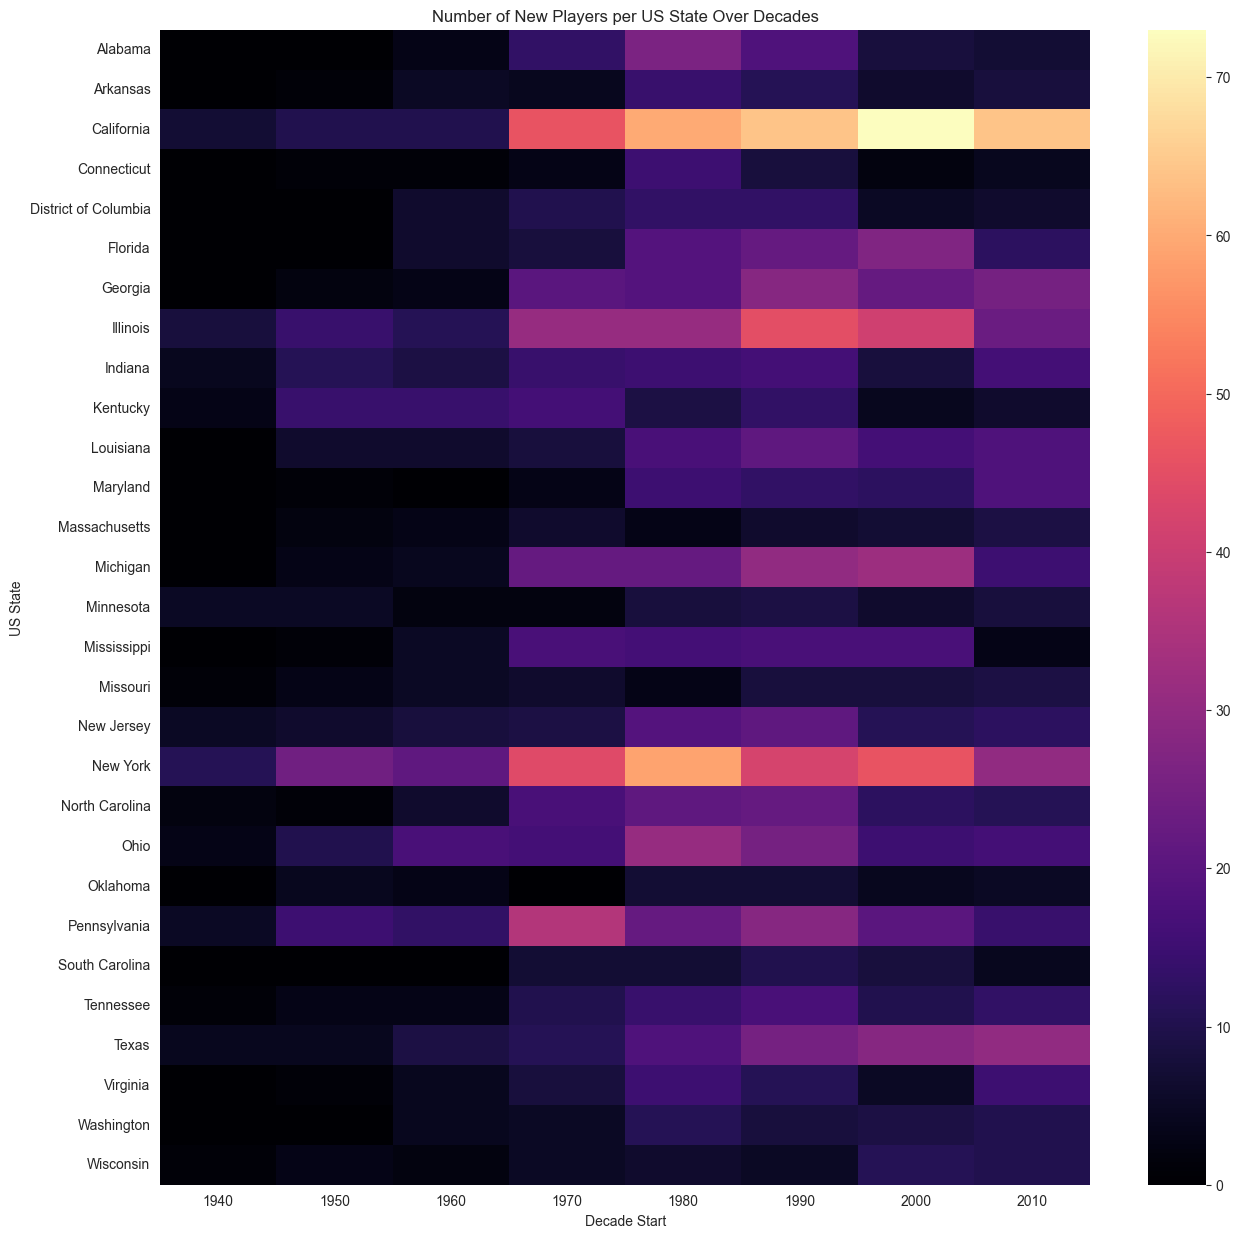

In [171]:
players_with_state = players_data[players_data["birth_state"].notna()]
valuable_states = players_with_state.groupby("birth_state").size() >= 30
valuable_states_names = valuable_states[valuable_states].index
states_popularity = players_data[players_data["birth_state"].isin(valuable_states_names)]
states_popularity = states_popularity.groupby(["decade_start", "birth_state"]).size().reset_index()
states_popularity.columns = ["decade_start", "birth_state", "num_players"]

data_pivot = states_popularity.pivot("birth_state", "decade_start", "num_players")
data_pivot = data_pivot.fillna(0)

plt.figure(figsize=(15, 15))
sns.heatmap(data_pivot, cmap="magma")
plt.title("Number of New Players per US State Over Decades")
plt.xlabel("Decade Start")
plt.ylabel("US State")
plt.show()

## Players Statistics

In [216]:
player_stats = pd.read_csv("../datasets/visualisation_hw/Seasons_Stats.csv")

In [217]:
player_stats.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [218]:
player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24691 entries, 0 to 24690
Data columns (total 53 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  24691 non-null  int64  
 1   Year        24624 non-null  float64
 2   Player      24624 non-null  object 
 3   Pos         24624 non-null  object 
 4   Age         24616 non-null  float64
 5   Tm          24624 non-null  object 
 6   G           24624 non-null  float64
 7   GS          18233 non-null  float64
 8   MP          24138 non-null  float64
 9   PER         24101 non-null  float64
 10  TS%         24538 non-null  float64
 11  3PAr        18839 non-null  float64
 12  FTr         24525 non-null  float64
 13  ORB%        20792 non-null  float64
 14  DRB%        20792 non-null  float64
 15  TRB%        21571 non-null  float64
 16  AST%        22555 non-null  float64
 17  STL%        20792 non-null  float64
 18  BLK%        20792 non-null  float64
 19  TOV%        19582 non-nul

In [219]:
player_stats.drop(["Unnamed: 0", "blanl", "blank2"], axis=1, inplace=True)

In [220]:
player_stats.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


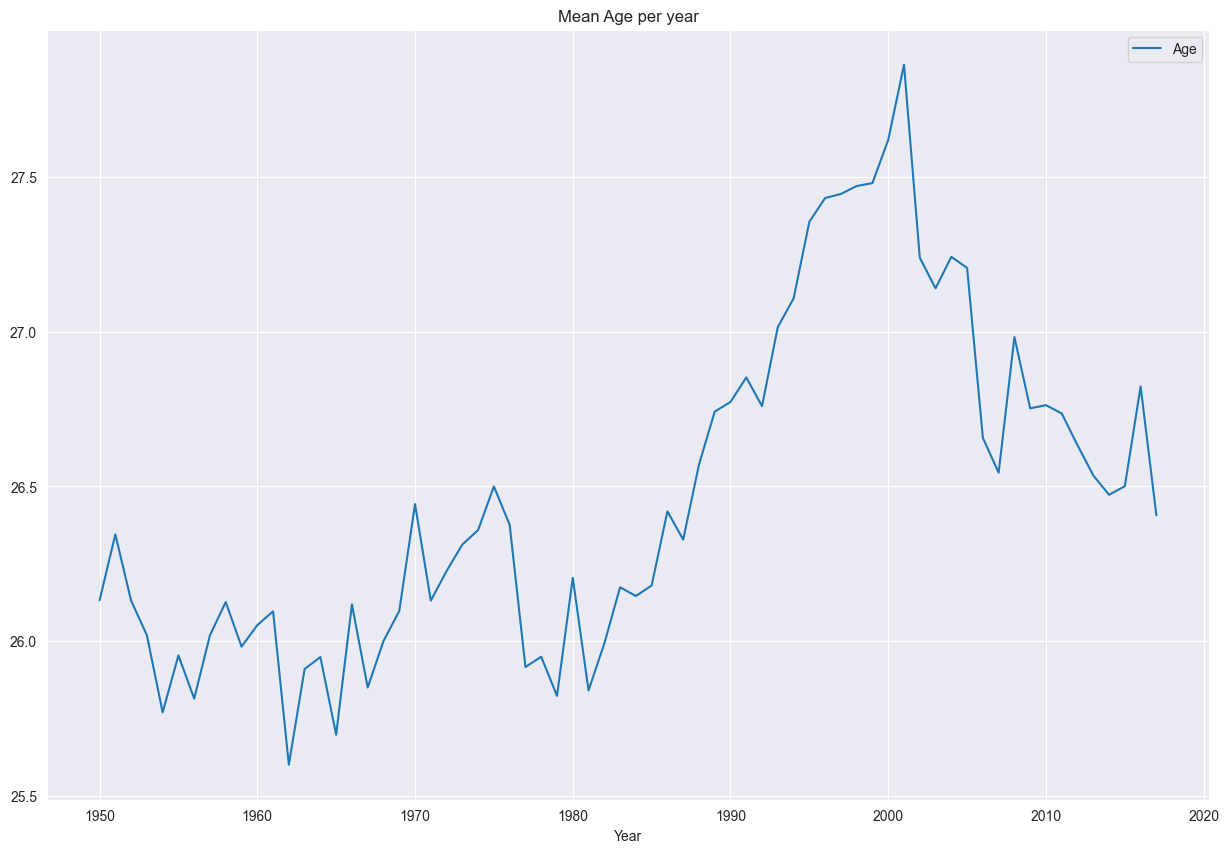

In [221]:
stats_by_year = player_stats.groupby("Year")
stats_by_year.aggregate({"Age": "mean"}).plot(kind="line", figsize=(15, 10))
plt.title("Mean Age per year")
plt.show()

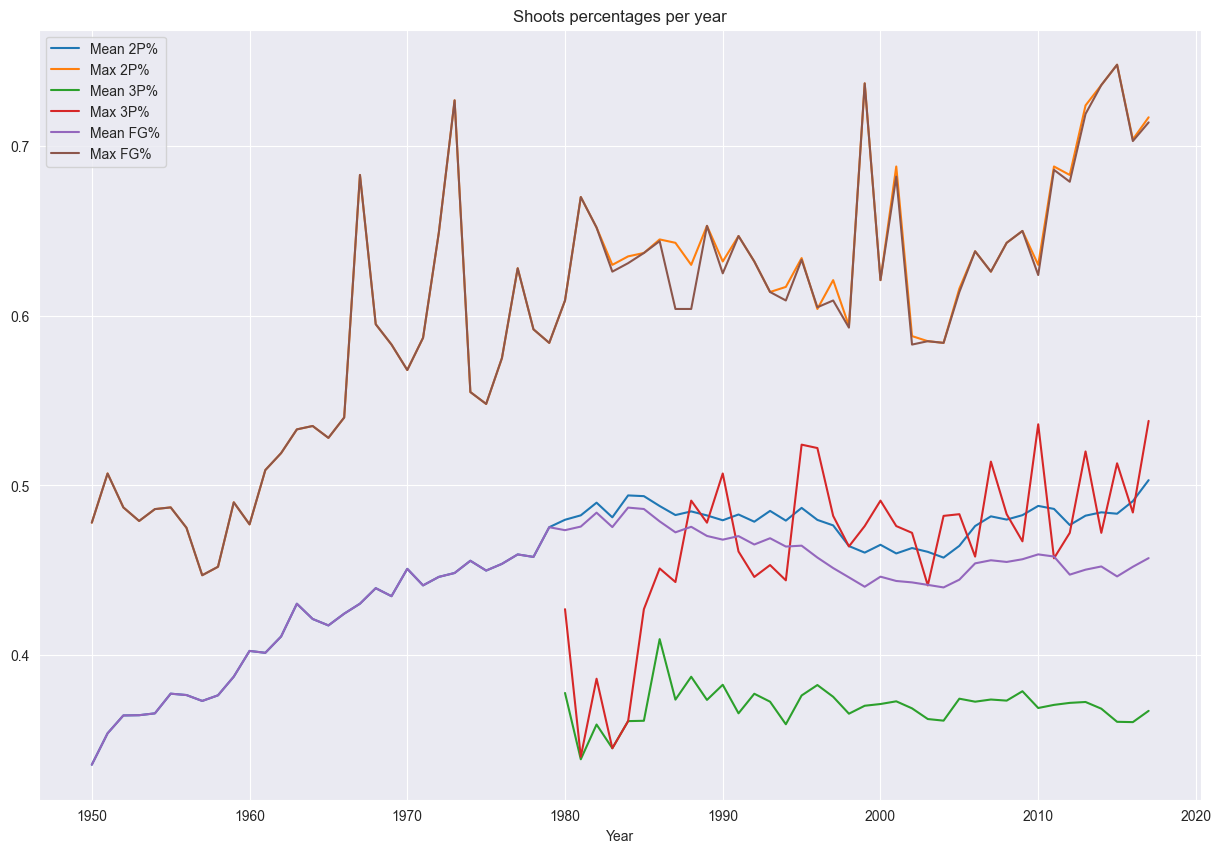

In [222]:
shoot_stats = pd.DataFrame(index=pd.Index([], name="Year"))
for shoot_type, shoot_count_threshold in (("2P", 50), ("3P", 25), ("FG", 50)):
    shoot_type_percent = f"{shoot_type}%"
    filtered_stats = player_stats[player_stats[shoot_type] > shoot_count_threshold]
    aggregated_stats = filtered_stats.groupby("Year")[shoot_type_percent].aggregate(["mean", "max"])
    aggregated_stats.rename(
        columns={"mean": f"Mean {shoot_type_percent}", "max": f"Max {shoot_type_percent}"}, inplace=True
    )
    shoot_stats = shoot_stats.merge(aggregated_stats, on="Year", how="outer")

shoot_stats.plot(kind="line", figsize=(15, 10))
plt.title(f"Shoots percentages per year")
plt.show()

In [269]:
player_stats["generalized_position"] = player_stats["Pos"][player_stats["Pos"].notna()].apply(lambda x: x.split("-")[0])
player_stats["generalized_position"][player_stats["generalized_position"].isin(["F", "G"])].count() / player_stats[
    "generalized_position"
].count()

0.01957439896036387

In [268]:
# player_stats["generalized_position"] = player_stats["generalized_position"][~player_stats["generalized_position"].isin(["F", "G"])]

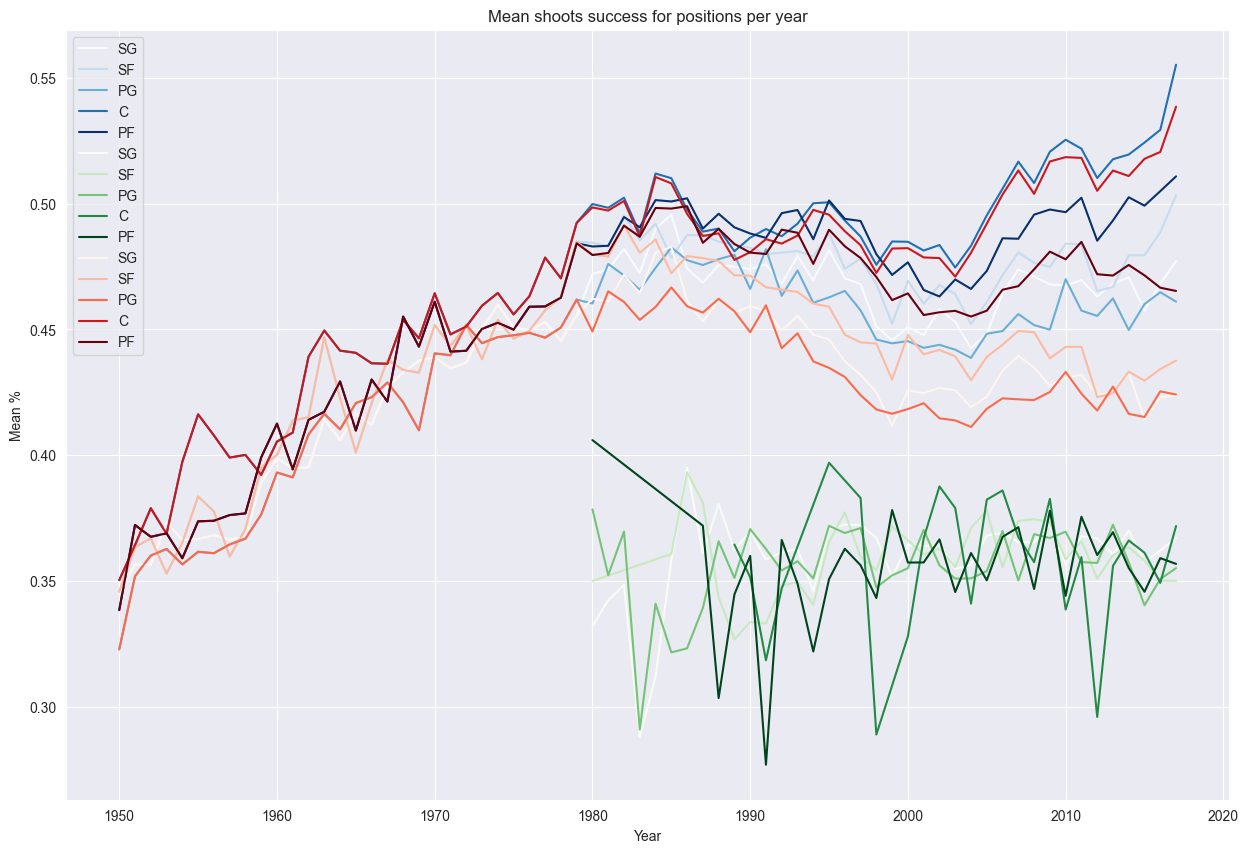

In [275]:
clear_positions = [
    pos for pos in player_stats["generalized_position"].unique() if isinstance(pos, str) and pos not in ["F", "G"]
]
plt.figure(figsize=(15, 10))
for shoot_type, shoot_count_threshold, color_map in (("2P", 50, cm.Blues), ("3P", 25, cm.Greens), ("FG", 50, cm.Reds)):
    filtered_stats = player_stats[player_stats[shoot_type] > shoot_count_threshold]
    aggregated_stats = filtered_stats.groupby(["Year", "Pos"])[f"{shoot_type}%"].aggregate("mean").reset_index()

    colors = color_map(np.linspace(0, 1, len(clear_positions)))
    for i, pos in enumerate(clear_positions):
        data_subset = aggregated_stats[aggregated_stats["Pos"] == pos]
        plt.plot(data_subset["Year"], data_subset[f"{shoot_type}%"], label=pos, color=colors[i])

plt.title("Mean shoots success for positions per year")
plt.xlabel("Year")
plt.ylabel(f"Mean shoots %")
plt.legend()
plt.show()